In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Dof"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn014701,MPPETSDRRPARMQNDGAHPPEPEQLPCPRCESTNTKFCYYNNYNL...,225,1
1,Achn040131,MNFSSIPAYLDPSNWQQQAPNPQTEGGNGSGSSSQLPQPPPQAPTH...,321,1
2,Achn050591,MQDPSTYQQIQPQFPEHEHLKCPRCDSTNTKFCYYNNYNLSQPRHY...,184,1
3,Achn058491,MEHKGLVPVLVLFLGFSFVLSCVAVPTSRSGPFSLVERNQFESPFL...,573,1
4,Achn091101,MIQELLGETSLIGGERKISLSNILEASSSLSPSPSPSPSSSSSAQE...,305,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
4623,0.024887,0.002262,0.000000,0.002262,0.002262,0.009050,0.002262,0.000000,0.002262,0.009050,...,0.004525,0.000000,0.0,0.000000,0.002262,0.000000,0.000000,0.004525,0.000000,0.004525
5749,0.009050,0.001810,0.001810,0.001810,0.000905,0.003620,0.001810,0.002715,0.000000,0.004525,...,0.002715,0.002715,0.0,0.000905,0.000905,0.001810,0.000905,0.000000,0.000000,0.000000
6485,0.014745,0.002681,0.004021,0.010054,0.000000,0.004692,0.000000,0.004692,0.004021,0.002681,...,0.000670,0.003351,0.0,0.001340,0.000000,0.002011,0.000000,0.000000,0.000000,0.003351
198,0.014663,0.002933,0.000000,0.002933,0.000000,0.000000,0.000000,0.002933,0.002933,0.008798,...,0.005865,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.005865,0.000000,0.000000
10453,0.037037,0.009259,0.000000,0.009259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.009259,0.000000,0.009259,0.000000,0.009259,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9024, 441)
X_test: (2257, 441)
y_train: (9024,)
y_test: (2257,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:10 631ms/step - accuracy: 0.5156 - loss: 0.6929

 28/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7265 - loss: 0.6768    

 58/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8042 - loss: 0.5971

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.5087

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8630 - loss: 0.4580 - val_accuracy: 0.9850 - val_loss: 0.0492


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0671

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0331 

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0314

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0314

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0320

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0322 - val_accuracy: 0.9917 - val_loss: 0.0285


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0799

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0264 

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0253

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0253

104/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0251

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0248 - val_accuracy: 0.9906 - val_loss: 0.0302


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0020

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0084 

 51/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0119

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0137

104/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0147

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0151 - val_accuracy: 0.9922 - val_loss: 0.0286


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0080

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0140 

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0165

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0163

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0160

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0160 - val_accuracy: 0.9917 - val_loss: 0.0325


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0024

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0174 

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0179

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0183

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0178

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0178 - val_accuracy: 0.9884 - val_loss: 0.0496


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0028

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0061 

 51/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0093

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0111

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0129

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0135 - val_accuracy: 0.9911 - val_loss: 0.0290


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0019

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0064 

 53/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0070

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0085

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0102

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.9917 - val_loss: 0.0302


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0120

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0144 

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0123

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0122

104/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0116

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0114 - val_accuracy: 0.9884 - val_loss: 0.0368


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0624

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0158 

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0113

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0101

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0097

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0095 - val_accuracy: 0.9906 - val_loss: 0.0322


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 6.6696e-04

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0058     

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0073

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0079

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0079

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0080 - val_accuracy: 0.9900 - val_loss: 0.0488


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0075

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0021 

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0027

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0042

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0063

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0069 - val_accuracy: 0.9906 - val_loss: 0.0335


Epoch 13/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0012

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0071 

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0072

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0071

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0070

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9906 - val_loss: 0.0329


Epoch 14/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 7.8189e-04

 28/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0061     

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0062

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0064

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0064

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9911 - val_loss: 0.0395



[Train Accuracy: 99.82% - Test Accuracy: 99.20%]


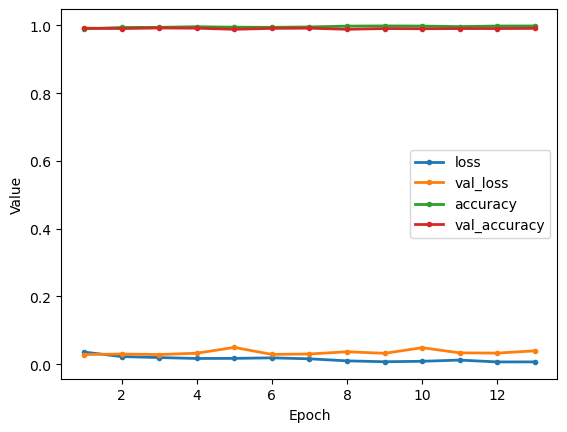

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
4623,0.006803,0.000000,0.000000,0.000000,0.0,0.002268,0.000000,0.000000,0.000000,0.002268,...,0.002268,0.0,0.0,0.0,0.002268,0.000000,0.0,0.0,0.0,0.0
5749,0.002717,0.000000,0.000000,0.000906,0.0,0.000000,0.000906,0.000906,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
6485,0.002012,0.000000,0.000671,0.003353,0.0,0.000671,0.000000,0.000671,0.002683,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.001341,0.0,0.0,0.0,0.0
198,0.005882,0.000000,0.000000,0.002941,0.0,0.000000,0.000000,0.002941,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
10453,0.009346,0.009346,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9024, 8915)
X_test: (2257, 8915)
y_train: (9024,)
y_test: (2257,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,282,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,325,761 (8.87 MB)

 Trainable params: 2,325,761 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:13 654ms/step - accuracy: 0.5000 - loss: 0.6931

  6/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5020 - loss: 0.6929   

 12/113 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5801 - loss: 0.6916 

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6513 - loss: 0.6882

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7058 - loss: 0.6809

 34/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7402 - loss: 0.6704

 42/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7695 - loss: 0.6524

 49/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7894 - loss: 0.6324

 56/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8057 - loss: 0.6105

 64/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8209 - loss: 0.5851

 71/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8321 - loss: 0.5636

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8417 - loss: 0.5432

 86/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8513 - loss: 0.5214

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8595 - loss: 0.5012

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8668 - loss: 0.4826

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8724 - loss: 0.4674

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8761 - loss: 0.4572 - val_accuracy: 0.9972 - val_loss: 0.0115


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 0.0082

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0059 

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0065

 22/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - loss: 0.0073

 29/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9990 - loss: 0.0075

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9988 - loss: 0.0079

 43/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9986 - loss: 0.0082

 50/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9985 - loss: 0.0084

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9984 - loss: 0.0084

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0086

 72/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0088

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 0.0090

 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9979 - loss: 0.0091

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9979 - loss: 0.0092

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9978 - loss: 0.0093

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9978 - loss: 0.0094

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9977 - loss: 0.0094 - val_accuracy: 0.9983 - val_loss: 0.0067


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0012

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022 

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0024

 22/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0023

 29/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0026

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0028

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0028

 51/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0028

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0028

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0027

 73/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0026

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0026

 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0025

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0024

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0024

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0023

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9989 - val_loss: 0.0079


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0029

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010 

 16/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9599e-04

 23/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8909e-04

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1497e-04

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5560e-04

 45/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1602e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8370e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5639e-04

 66/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3365e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1438e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0093e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8782e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7773e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6734e-04

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5769e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.5434e-04 - val_accuracy: 0.9989 - val_loss: 0.0086


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.1497e-04

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3877e-04 

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1642e-04

 22/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0771e-04

 29/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0320e-04

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0078e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0014e-04

 50/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8984e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8670e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0092e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0399e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0642e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0841e-04

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1026e-04

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1190e-04

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1325e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1406e-04 - val_accuracy: 0.9989 - val_loss: 0.0094


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 4.5407e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7256e-05 

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9720e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0380e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2070e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6287e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9124e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0688e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5443e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8913e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1196e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.3638e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6806e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9203e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1111e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2617e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.3496e-05 - val_accuracy: 0.9989 - val_loss: 0.0093


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.1449e-04

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9283e-04 

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5463e-04

 23/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3199e-04

 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1756e-04

 38/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0856e-04

 46/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0030e-04

 53/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4526e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9834e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5968e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2924e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0647e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8316e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6187e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4569e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3365e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.3035e-05 - val_accuracy: 0.9989 - val_loss: 0.0100


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 2.7884e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2477e-05 

 17/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5505e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8966e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2445e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4682e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5612e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5869e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5933e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5907e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5844e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5734e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5539e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5299e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5106e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4907e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.4878e-05 - val_accuracy: 0.9983 - val_loss: 0.0117


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.7104e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8549e-05 

 16/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0942e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2939e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3526e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3524e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3539e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3459e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3642e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3853e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4000e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4035e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4048e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5717e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7091e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.9130e-05 - val_accuracy: 0.9983 - val_loss: 0.0134


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.4057e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1581e-05 

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3617e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0876e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7509e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0707e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3205e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4580e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5245e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5404e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5278e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4980e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4530e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4123e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3693e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3297e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.2950e-05 - val_accuracy: 0.9989 - val_loss: 0.0113


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.0895e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0393e-05 

 15/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7145e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8246e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8463e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8568e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0622e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1597e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2231e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2691e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2939e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3540e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4279e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4878e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5296e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.5478e-05 - val_accuracy: 0.9983 - val_loss: 0.0123


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.5171e-06

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1028e-05 

 16/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4463e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5404e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5550e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5452e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5184e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4965e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5500e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5878e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6138e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6288e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6375e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6530e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6885e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.7129e-05 - val_accuracy: 0.9989 - val_loss: 0.0113


Epoch 13/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.3075e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2331e-05 

 16/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3804e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3529e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3053e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2789e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2508e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2375e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2230e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2096e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1990e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1885e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1788e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1694e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1593e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1484e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1436e-05 - val_accuracy: 0.9989 - val_loss: 0.0119



[Train Accuracy: 100.00% - Test Accuracy: 99.78%]

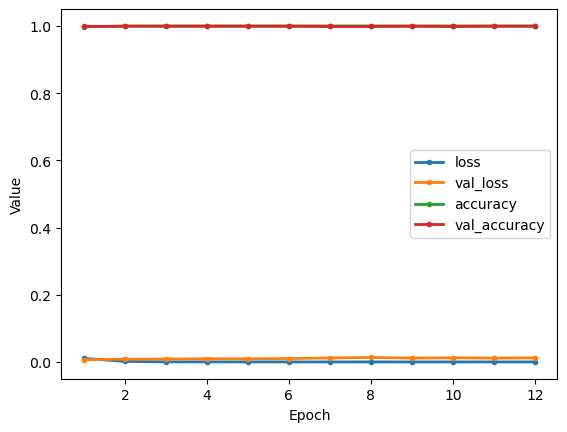

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

40/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

41/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
4623,0.002273,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5749,0.000907,0.0,0.000000,0.0,0.0,0.000000,0.000907,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6485,0.000671,0.0,0.000671,0.0,0.0,0.000671,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.002950,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10453,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,403,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,444,481 (150.47 MB)

 Trainable params: 39,444,481 (150.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:35 857ms/step - accuracy: 0.5312 - loss: 0.6931

  2/113 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.5156 - loss: 0.6932 

  3/113 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.5139 - loss: 0.6932

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.5133 - loss: 0.6932

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.5157 - loss: 0.6931

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.5187 - loss: 0.6930

  7/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.5199 - loss: 0.6930

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.5215 - loss: 0.6929

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.5215 - loss: 0.6929

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.5201 - loss: 0.6929

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.5197 - loss: 0.6928

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.5183 - loss: 0.6928

 13/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.5170 - loss: 0.6928

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.5158 - loss: 0.6928

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.5149 - loss: 0.6927

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.5140 - loss: 0.6927

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.5138 - loss: 0.6926

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.5143 - loss: 0.6925

 19/113 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.5158 - loss: 0.6925

 20/113 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5180 - loss: 0.6924

 21/113 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5209 - loss: 0.6923

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.5242 - loss: 0.6922

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.5280 - loss: 0.6920

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.5320 - loss: 0.6919

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.5362 - loss: 0.6917

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.5406 - loss: 0.6915

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.5452 - loss: 0.6913

 28/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5498 - loss: 0.6911

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5543 - loss: 0.6908

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5590 - loss: 0.6906

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.5636 - loss: 0.6903

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5683 - loss: 0.6899

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5729 - loss: 0.6896

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5774 - loss: 0.6892

 35/113 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5819 - loss: 0.6888

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5863 - loss: 0.6884

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5907 - loss: 0.6879

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5949 - loss: 0.6874

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5991 - loss: 0.6869

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.6032 - loss: 0.6863 

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.6073 - loss: 0.6857

 42/113 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.6112 - loss: 0.6851

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.6151 - loss: 0.6844

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.6190 - loss: 0.6836

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.6228 - loss: 0.6828

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.6265 - loss: 0.6820

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.6301 - loss: 0.6811

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6337 - loss: 0.6801

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6372 - loss: 0.6791

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6406 - loss: 0.6780

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6439 - loss: 0.6769

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6472 - loss: 0.6757

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6504 - loss: 0.6744

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6536 - loss: 0.6731

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.6567 - loss: 0.6718

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6597 - loss: 0.6704

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6627 - loss: 0.6689

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6656 - loss: 0.6673

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6685 - loss: 0.6657

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6713 - loss: 0.6641

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6741 - loss: 0.6624

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6768 - loss: 0.6606

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6795 - loss: 0.6588

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6821 - loss: 0.6570

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6847 - loss: 0.6551

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6872 - loss: 0.6532

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6897 - loss: 0.6512

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6921 - loss: 0.6492

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6945 - loss: 0.6472

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6968 - loss: 0.6451

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.6991 - loss: 0.6430

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7014 - loss: 0.6409

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7036 - loss: 0.6388

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7058 - loss: 0.6366

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7080 - loss: 0.6345

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7101 - loss: 0.6323

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7122 - loss: 0.6301

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7143 - loss: 0.6279

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7163 - loss: 0.6257

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7183 - loss: 0.6234

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7202 - loss: 0.6212

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7222 - loss: 0.6189

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7241 - loss: 0.6167

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7259 - loss: 0.6144

 85/113 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.7278 - loss: 0.6122

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7296 - loss: 0.6099

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7314 - loss: 0.6076

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7332 - loss: 0.6054

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7349 - loss: 0.6031

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7366 - loss: 0.6009

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7383 - loss: 0.5986

 92/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7399 - loss: 0.5964

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7416 - loss: 0.5942

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7432 - loss: 0.5920

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7448 - loss: 0.5897

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7464 - loss: 0.5875

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7479 - loss: 0.5853

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7494 - loss: 0.5831

 99/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7509 - loss: 0.5810

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7524 - loss: 0.5788

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7539 - loss: 0.5766

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7553 - loss: 0.5744

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7568 - loss: 0.5723

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7582 - loss: 0.5702

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7596 - loss: 0.5680

106/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7609 - loss: 0.5659

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7623 - loss: 0.5638

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7636 - loss: 0.5617

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7649 - loss: 0.5597

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7662 - loss: 0.5576

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7675 - loss: 0.5556

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7688 - loss: 0.5535

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7700 - loss: 0.5515

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 0.7713 - loss: 0.5495 - val_accuracy: 0.9972 - val_loss: 0.0149


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 1.0000 - loss: 0.0059

  2/113 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 1.0000 - loss: 0.0059

  3/113 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 1.0000 - loss: 0.0061

  4/113 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 1.0000 - loss: 0.0061

  5/113 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 0.0060

  6/113 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 1.0000 - loss: 0.0060

  7/113 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.9994 - loss: 0.0067

  8/113 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9987 - loss: 0.0073

  9/113 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9983 - loss: 0.0077

 10/113 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9980 - loss: 0.0080

 11/113 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9978 - loss: 0.0082

 12/113 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9976 - loss: 0.0083

 13/113 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.9975 - loss: 0.0084

 14/113 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.9975 - loss: 0.0085

 15/113 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9974 - loss: 0.0085

 16/113 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9974 - loss: 0.0086

 17/113 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9972 - loss: 0.0087

 18/113 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9971 - loss: 0.0088

 19/113 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9971 - loss: 0.0089

 20/113 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9970 - loss: 0.0089

 21/113 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9970 - loss: 0.0090

 22/113 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.9970 - loss: 0.0090

 23/113 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9969 - loss: 0.0091

 24/113 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9969 - loss: 0.0091

 25/113 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9969 - loss: 0.0092

 26/113 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9968 - loss: 0.0092

 27/113 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 0.9968 - loss: 0.0092

 28/113 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9968 - loss: 0.0093

 29/113 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9968 - loss: 0.0093

 30/113 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9968 - loss: 0.0093

 31/113 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9968 - loss: 0.0093

 32/113 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9968 - loss: 0.0093

 33/113 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9969 - loss: 0.0093

 34/113 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9969 - loss: 0.0092

 35/113 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9969 - loss: 0.0093

 36/113 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9969 - loss: 0.0093

 37/113 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9969 - loss: 0.0093

 38/113 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9969 - loss: 0.0093

 39/113 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9969 - loss: 0.0093

 40/113 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.9969 - loss: 0.0093

 41/113 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.9969 - loss: 0.0093

 42/113 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9969 - loss: 0.0093

 43/113 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9969 - loss: 0.0093

 44/113 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9969 - loss: 0.0092

 45/113 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9970 - loss: 0.0092

 46/113 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9970 - loss: 0.0092

 47/113 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9970 - loss: 0.0092

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9970 - loss: 0.0092 

 49/113 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.9970 - loss: 0.0091

 50/113 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9970 - loss: 0.0091

 51/113 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9970 - loss: 0.0091

 52/113 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9971 - loss: 0.0090

 53/113 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9971 - loss: 0.0090

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9971 - loss: 0.0090

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9971 - loss: 0.0089

 56/113 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9971 - loss: 0.0089

 57/113 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9971 - loss: 0.0089

 58/113 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9972 - loss: 0.0088

 59/113 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9972 - loss: 0.0088

 60/113 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9972 - loss: 0.0088

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9972 - loss: 0.0088

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9972 - loss: 0.0087

 63/113 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9972 - loss: 0.0087

 64/113 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9972 - loss: 0.0087

 65/113 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9973 - loss: 0.0086

 66/113 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9973 - loss: 0.0086

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9973 - loss: 0.0086

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9973 - loss: 0.0086

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9973 - loss: 0.0085

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9973 - loss: 0.0085

 71/113 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9973 - loss: 0.0085

 72/113 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9973 - loss: 0.0084

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9974 - loss: 0.0084

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9974 - loss: 0.0084

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9974 - loss: 0.0084

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9974 - loss: 0.0083

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9974 - loss: 0.0083

 78/113 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9974 - loss: 0.0083

 79/113 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9974 - loss: 0.0083

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9974 - loss: 0.0082

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9974 - loss: 0.0082

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9974 - loss: 0.0082

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9975 - loss: 0.0082

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9975 - loss: 0.0081

 85/113 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9975 - loss: 0.0081

 86/113 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9975 - loss: 0.0081

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9975 - loss: 0.0080

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9975 - loss: 0.0080

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9975 - loss: 0.0080

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9975 - loss: 0.0080

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9975 - loss: 0.0080

 92/113 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9975 - loss: 0.0079

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9975 - loss: 0.0079

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0079

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9976 - loss: 0.0079

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9976 - loss: 0.0079

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9976 - loss: 0.0079

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9976 - loss: 0.0078

 99/113 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9976 - loss: 0.0078

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9976 - loss: 0.0078

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9976 - loss: 0.0078

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9976 - loss: 0.0078

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9976 - loss: 0.0078

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9976 - loss: 0.0077

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9976 - loss: 0.0077

106/113 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9976 - loss: 0.0077

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9976 - loss: 0.0077

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9977 - loss: 0.0077

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9977 - loss: 0.0077

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9977 - loss: 0.0077

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9977 - loss: 0.0077

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9977 - loss: 0.0076

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9977 - loss: 0.0076

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.9977 - loss: 0.0076 - val_accuracy: 0.9978 - val_loss: 0.0051


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 1.0000 - loss: 0.0014

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 0.0014

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 0.0014

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 0.0015

  5/113 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 0.0015

  6/113 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 0.0016

  7/113 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 0.0016

  8/113 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 0.0016

  9/113 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 0.0016

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 0.0016

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 0.0015

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 0.0015

 14/113 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 0.0015

 15/113 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 16/113 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 17/113 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 18/113 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 19/113 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 20/113 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 21/113 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 0.0014

 22/113 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 0.0014

 23/113 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 0.0014

 24/113 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 0.0014

 25/113 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 0.0014

 26/113 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0014

 27/113 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 0.0014

 28/113 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 0.0014

 29/113 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 0.0014

 30/113 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 0.0014

 31/113 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 0.0014

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 0.0013

 33/113 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 0.0013

 34/113 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 0.0013

 35/113 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 0.0013

 36/113 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 0.0013

 37/113 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 0.0013

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0013

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0013

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0013

 41/113 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0013

 42/113 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0013

 43/113 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0013

 44/113 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0013

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0012 

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 49/113 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 50/113 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 51/113 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 56/113 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 57/113 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 58/113 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 63/113 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 64/113 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 65/113 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 71/113 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 72/113 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 78/113 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 85/113 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 92/113 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 0.0011

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 0.0010

 99/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 0.0010

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0010

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 0.0010

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 0.0010

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 0.0010

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0010

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0010

106/113 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0010

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0010

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0010

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0010

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0010

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0010

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0010

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0010

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9978 - val_loss: 0.0051


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 1.0000 - loss: 3.1099e-04

  2/113 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 2.9199e-04

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 1.0000 - loss: 2.9139e-04

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 1.0000 - loss: 2.9972e-04

  5/113 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 3.0280e-04

  6/113 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 3.0659e-04

  7/113 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 3.1270e-04

  8/113 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 3.1501e-04

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 3.1547e-04

 10/113 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 3.1470e-04

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 3.1385e-04

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 3.1267e-04

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 3.1553e-04

 14/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 3.1836e-04

 15/113 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 3.2128e-04

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 3.2391e-04

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 3.2554e-04

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 3.2653e-04

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 3.2703e-04

 20/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 3.2746e-04

 21/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 3.2759e-04

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 3.2750e-04

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 3.2722e-04

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 3.2689e-04

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 3.2629e-04

 26/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 3.2592e-04

 27/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 3.2534e-04

 28/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 3.2469e-04

 29/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 3.2412e-04

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.2337e-04

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.2279e-04

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.2244e-04

 33/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.2196e-04

 34/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.2146e-04

 35/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.2096e-04

 36/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.2104e-04

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2106e-04

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2098e-04

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2080e-04

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 3.2061e-04

 41/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2034e-04

 42/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2030e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2020e-04

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.2006e-04 

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.1984e-04

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.1957e-04

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.1927e-04

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.1896e-04

 49/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.1859e-04

 50/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.1824e-04

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1792e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1791e-04

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.1824e-04

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.1856e-04

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.1885e-04

 56/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.1912e-04

 57/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.2083e-04

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.2241e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.2400e-04

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.2547e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.2685e-04

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.2815e-04

 63/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.2940e-04

 64/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.3056e-04

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3168e-04

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3275e-04

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.3376e-04

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3472e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3566e-04

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.3660e-04

 71/113 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.3750e-04

 72/113 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.3836e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.3920e-04

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.4000e-04

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.4075e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.4144e-04

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.4211e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.4277e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.4342e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.4403e-04

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.4461e-04

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.4515e-04

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.4569e-04

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.4626e-04

 85/113 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.4679e-04

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.4731e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.4779e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.4823e-04

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.4865e-04

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.4903e-04

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.4937e-04

 92/113 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.4972e-04

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.5003e-04

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.5031e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.5054e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.5076e-04

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.5095e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.5111e-04

 99/113 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.5126e-04

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.5139e-04

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.5153e-04

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.5165e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.5175e-04

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.5183e-04

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.5189e-04

106/113 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.5193e-04

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.5195e-04

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.5195e-04

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.5193e-04

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.5201e-04

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.5207e-04

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.5211e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.5215e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 3.5220e-04 - val_accuracy: 0.9978 - val_loss: 0.0064


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 1.0000 - loss: 1.6858e-04

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 1.0000 - loss: 1.5695e-04

  3/113 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.5881e-04

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 1.5637e-04

  5/113 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 1.6126e-04

  6/113 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 1.6595e-04

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 1.6887e-04

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 1.7055e-04

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 1.7096e-04

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 1.7049e-04

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.7537e-04

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.7920e-04

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.8230e-04

 14/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.8477e-04

 15/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.8827e-04

 16/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.9089e-04

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9284e-04

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9442e-04

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.9582e-04

 20/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.9707e-04

 21/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.9801e-04

 22/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.9865e-04

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.0037e-04

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 2.0173e-04

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 2.0275e-04

 26/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 2.0371e-04

 27/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 2.0466e-04

 28/113 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.0564e-04

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.0658e-04

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.0732e-04

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.0837e-04

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.0920e-04

 33/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.0988e-04

 34/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.1040e-04

 35/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.1081e-04

 36/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.1113e-04

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1133e-04

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1144e-04

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1153e-04

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1155e-04

 41/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1150e-04

 42/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1139e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1132e-04

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.1124e-04 

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.1115e-04

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.1100e-04

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.1082e-04

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.1063e-04

 49/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.1042e-04

 50/113 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.1019e-04

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0995e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 2.0969e-04

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0940e-04

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0923e-04

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0905e-04

 56/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0885e-04

 57/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0863e-04

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0838e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0811e-04

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0784e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0797e-04

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0807e-04

 63/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0816e-04

 64/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0822e-04

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 2.0826e-04

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.0830e-04

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 2.0834e-04

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 2.0837e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.0837e-04

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.0835e-04

 71/113 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.0832e-04

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.0826e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.0819e-04

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.0812e-04

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.0805e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.0798e-04

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.0791e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.0783e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.0773e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.0765e-04

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.0755e-04

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.0745e-04

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.0738e-04

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.0730e-04

 85/113 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.0722e-04

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0713e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0703e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0692e-04

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0681e-04

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0670e-04

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0657e-04

 92/113 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0645e-04

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0632e-04

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0617e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0604e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0591e-04

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0577e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0563e-04

 99/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0548e-04

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.0532e-04

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.0515e-04

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.0498e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.0481e-04

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.0466e-04

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.0449e-04

106/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.0432e-04

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.0414e-04

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.0395e-04

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.0376e-04

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.0357e-04

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.0338e-04

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.0319e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.0300e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 2.0282e-04 - val_accuracy: 0.9972 - val_loss: 0.0071


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 1.0000 - loss: 9.0508e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 8.5933e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 9.0866e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 9.1434e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 9.1143e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 9.0429e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 9.0501e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 9.1000e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 9.1318e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 9.1449e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 9.1503e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 9.2803e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 9.4053e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 9.4953e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 9.5623e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 9.6025e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 9.6285e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 9.6467e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 9.6693e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 9.6773e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 9.6833e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.6768e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.6723e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.6659e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.6543e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.6450e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.6536e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.6641e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.6713e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.6776e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.6827e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.6821e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.6947e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.7485e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.7935e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.8478e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.8953e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.9386e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.9765e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.0011e-04

 41/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.0039e-04

 42/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.0066e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.0092e-04 

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.0118e-04

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.0141e-04

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.0165e-04

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.0185e-04

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.0202e-04

 49/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.0217e-04

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.0231e-04

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.0248e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.0262e-04

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0274e-04

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0295e-04

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 1.0312e-04

 56/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.0327e-04

 57/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.0341e-04

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.0354e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.0367e-04

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.0379e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.0389e-04

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.0397e-04

 63/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.0405e-04

 64/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.0413e-04

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0418e-04

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0423e-04

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0426e-04

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0428e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0431e-04

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0433e-04

 71/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0434e-04

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.0434e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.0433e-04

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.0432e-04

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.0431e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.0428e-04

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.0425e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.0422e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.0418e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.0415e-04

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.0412e-04

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.0411e-04

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.0409e-04

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.0407e-04

 85/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.0405e-04

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.0403e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.0400e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.0396e-04

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.0392e-04

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 92/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.0391e-04

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.0391e-04

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.0391e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 99/113 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.0389e-04

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.0387e-04

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.0385e-04

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.0383e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.0393e-04

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.0402e-04

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.0410e-04

106/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.0418e-04

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.0425e-04

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.0432e-04

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.0437e-04

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.0442e-04

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.0447e-04

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.0451e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.0454e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 1.0457e-04 - val_accuracy: 0.9967 - val_loss: 0.0089


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 1.0000 - loss: 6.0521e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 6.4684e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.2866e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 6.6688e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 6.7641e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 6.7949e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.8027e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.7782e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 6.7590e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 6.7280e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 6.7148e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 6.6942e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 6.7251e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 6.7435e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 6.7448e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 6.7435e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 6.7517e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 6.7475e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 6.7504e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 6.7439e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 6.7407e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 6.7409e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 6.7404e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 6.7353e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 6.7274e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 6.7177e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 6.7063e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 6.6943e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 6.7082e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 6.7167e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 6.7219e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 6.7229e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 6.7334e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 6.7434e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 6.7578e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 6.7734e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 6.7850e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.7951e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.8019e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.8070e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.8106e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.8172e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.8250e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.8345e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 6.8445e-05 

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 6.8526e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 6.8585e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 6.8635e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 6.8678e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 6.8705e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 6.8733e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 6.8757e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8784e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8811e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8829e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8835e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8826e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.8813e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.8790e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.8772e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.8762e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.8747e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.8723e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 6.8691e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.8660e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.8626e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.8605e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.8580e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.8552e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.8516e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.8475e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.8447e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.8434e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.8417e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.8398e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.8378e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.8357e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.8343e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 6.8324e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 6.8304e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 6.8280e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 6.8253e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 6.8224e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 6.8193e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 6.8157e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 6.8120e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 6.8079e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 6.8040e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 6.8002e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 6.7961e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 6.7920e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 6.7879e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 6.7857e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 6.7832e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 6.7804e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.7774e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.7741e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.7708e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.7674e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.7639e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.7603e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.7565e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.7527e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.7487e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.7447e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 6.7406e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.7372e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.7340e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.7307e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.7275e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.7243e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.7216e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 6.7187e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 6.7158e-05 - val_accuracy: 0.9972 - val_loss: 0.0074


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 1.0000 - loss: 3.0515e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 6.6583e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 1.0000 - loss: 7.0768e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 1.0000 - loss: 7.0817e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 7.1042e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 6.9760e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 6.8079e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 6.6314e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 6.4672e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.3279e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 6.2109e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 6.1213e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 6.0301e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 5.9426e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.8636e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.7863e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.7446e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.7027e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.6589e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.6212e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 5.6359e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.6515e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6622e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6661e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6637e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 5.6646e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6660e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6630e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6624e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 5.6636e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.6624e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.6617e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.6584e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.6554e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.6525e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.6501e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.6477e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.6463e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.6427e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 5.6387e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 5.6352e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 5.6317e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.6265e-05 

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.6222e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.6164e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.6102e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.6043e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.5999e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.5939e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.5885e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.5830e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.5774e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.5711e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.5642e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.5563e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.5534e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5558e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5573e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5579e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5590e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5603e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5608e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5616e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 5.5629e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 5.5637e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 5.5641e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 5.5642e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 5.5639e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 5.5670e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 5.5704e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5735e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5765e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5791e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5812e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5833e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5847e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5855e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 5.5858e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 5.5858e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 5.5955e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 5.6046e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 5.6130e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 5.6207e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 5.6279e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 5.6344e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 5.6406e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 5.6463e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 5.6516e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 5.6566e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 5.6619e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 5.6667e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.6710e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.6750e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.6789e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.6825e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.6858e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.6888e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 5.6914e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 5.6942e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 5.6971e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 5.6997e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 5.7018e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 5.7036e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 5.7052e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 5.7064e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7082e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7097e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7115e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7129e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7145e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7158e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7169e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 5.7177e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 5.7186e-05 - val_accuracy: 0.9978 - val_loss: 0.0056


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 23s 211ms/step - accuracy: 1.0000 - loss: 3.9352e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 4.8401e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 5.0284e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 4.9984e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 5.0778e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 5.1236e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 5.0868e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 5.0582e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 5.0155e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 4.9855e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 4.9405e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 4.8970e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 4.8992e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 4.8900e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 4.8977e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 4.8936e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 4.9471e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 4.9828e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 5.0030e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 5.0160e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 5.0265e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 5.0332e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 5.0335e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 5.0378e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 5.0389e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.0427e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.1401e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.2269e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.3029e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.3689e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.4253e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.4744e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.5190e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.5598e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.5961e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.6273e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.6610e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.6901e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.7154e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.7369e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 5.7550e-05 

 42/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 5.7718e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 5.7874e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 5.8014e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 5.8133e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.8251e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.8356e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.8440e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.8516e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.8580e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.8640e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.8692e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.8746e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.8794e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.8840e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.8871e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.8889e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.8893e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.8896e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.8890e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.8875e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.8850e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8816e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8772e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8724e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8680e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8631e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8576e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.8515e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.8452e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.8387e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.8325e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.8258e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.8195e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.8129e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.8062e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.7992e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.7920e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.7847e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.7772e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.7697e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.7620e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.7542e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.7469e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.7397e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.7347e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.7299e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.7248e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.7197e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.7141e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.7130e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.7116e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.7098e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.7083e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.7067e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.7046e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.7025e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.7001e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.6975e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.6947e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.6920e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.6896e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.6870e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.6843e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.6815e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6785e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6754e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6724e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6691e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6662e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6632e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6604e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.6576e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 5.6548e-05 - val_accuracy: 0.9978 - val_loss: 0.0056


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - accuracy: 1.0000 - loss: 3.7875e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 3.5668e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 3.3432e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 3.4251e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 1.0000 - loss: 3.3778e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 3.3395e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 3.2986e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 3.2452e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 3.1950e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 3.1456e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 3.0997e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 3.0595e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 3.0362e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 3.0215e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 3.0039e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 2.9852e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 3.0192e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 3.0443e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 3.0626e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 3.0753e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 3.0864e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 3.0928e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 3.0964e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 3.0975e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 3.0976e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.0997e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.1136e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.1259e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.1371e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.1449e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.1509e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 3.1556e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 3.1590e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 3.1613e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 3.1629e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 3.1661e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.1833e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.1982e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.2106e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.2212e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.2305e-05 

 42/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.2402e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.2488e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.2562e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.2630e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.2686e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.2737e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 3.2778e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 3.2809e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 3.2831e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 3.2846e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 3.2854e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.2863e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 3.2900e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 3.2936e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 3.2963e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 3.3054e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 3.3134e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 3.3206e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 3.3273e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 3.3333e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 3.3385e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.3432e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.3479e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.3521e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.3562e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.3608e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.3651e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.3691e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3729e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3763e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3795e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3823e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3849e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3871e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3889e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.3909e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 3.3926e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 3.3942e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 3.3953e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 3.3961e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 3.3969e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.3976e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.3978e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.3978e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.3976e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.3972e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.3967e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.3960e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.3952e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.3942e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.3931e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.3932e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.3930e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.3926e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.3919e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.3910e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.3900e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.3888e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.3875e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.3862e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.3847e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.3830e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.3814e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.3804e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.3794e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.3783e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.3770e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.3760e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.3748e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.3737e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.3724e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.3711e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 3.3699e-05 - val_accuracy: 0.9978 - val_loss: 0.0074


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 1.0000 - loss: 1.5802e-04

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 1.2266e-04

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 1.0000 - loss: 1.0709e-04

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 9.5653e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 8.6867e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 8.0058e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 7.4718e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 7.0510e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 6.7263e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 6.4343e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 6.1979e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 5.9841e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 5.7915e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 5.6188e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 5.4632e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 5.3330e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 5.2107e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 5.0991e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 4.9957e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 4.8992e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.8090e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.7235e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.6433e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.5660e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.5019e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.4403e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.3814e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.3239e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 4.2692e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 4.2176e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 4.1707e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.1249e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.0889e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.0633e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.0510e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.0404e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.0289e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.0161e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.0025e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.9906e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 3.9781e-05 

 42/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.9653e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 3.9521e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 3.9388e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.9252e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 3.9112e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 3.8974e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 3.8857e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.8734e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.8609e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.8481e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.8351e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.8226e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 3.8105e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 3.7983e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.7862e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.7738e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.7615e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.7491e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.7372e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.7251e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.7135e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.7018e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.6905e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.6791e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.6676e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.6567e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.6458e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.6349e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.6246e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 3.6142e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.6041e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.5938e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.5844e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.5751e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.5659e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.5565e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.5473e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.5381e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.5288e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.5195e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.5104e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.5012e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 3.4919e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.4828e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.4736e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.4646e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.4556e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.4466e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.4378e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 3.4290e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.4208e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.4128e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.4047e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.3967e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.3888e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.3811e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.3734e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.3656e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.3578e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 3.3503e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.3429e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 3.3355e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 3.3285e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 3.3216e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.3148e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.3084e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.3020e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.2955e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.2891e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.2827e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.2762e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 3.2697e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 3.2634e-05 - val_accuracy: 0.9972 - val_loss: 0.0078


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 24s 216ms/step - accuracy: 1.0000 - loss: 2.2604e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.6329e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 2.5377e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 2.3993e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 2.2755e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 2.2662e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 2.2687e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 2.2567e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 2.2380e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 2.4064e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 2.5239e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 2.6014e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 2.6509e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 2.6881e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 2.7132e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 2.7306e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 2.7420e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 2.7449e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 2.7418e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 2.7345e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.7292e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.7213e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.7105e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.6989e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.6885e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.6802e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.6705e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.6624e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.6547e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.6462e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.6370e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.6274e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 2.6316e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 2.6351e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.6397e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.6425e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.6450e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.6465e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.6470e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.6490e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.6504e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.6505e-05 

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.6504e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 2.6496e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 2.6479e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 2.6454e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 2.6423e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.6388e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.6349e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.6303e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.6251e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.6195e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.6134e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.6089e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.6039e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.5985e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.5929e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.5871e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.5813e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.5761e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.5706e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.5648e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 2.5589e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.5529e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.5473e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.5421e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.5366e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.5312e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.5259e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.5205e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 2.5150e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 2.5100e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.5049e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.4998e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.4944e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.4892e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.4867e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.4843e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.4816e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.4787e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.4757e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.4726e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.4695e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.4662e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.4630e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.4596e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.4562e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.4529e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.4495e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.4461e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.4428e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4399e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4370e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4339e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4307e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4287e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4265e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.4244e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.4222e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.4200e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.4176e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.4152e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.4127e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.4102e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 2.4077e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.4050e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.4023e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.3996e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.3969e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.3942e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.3915e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.3887e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 2.3860e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.3833e-05 - val_accuracy: 0.9972 - val_loss: 0.0080



[Train Accuracy: 100.00% - Test Accuracy: 99.56%]


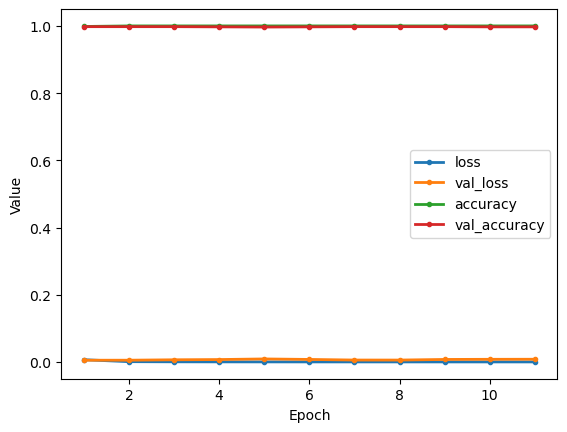

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step

 5/71 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

 9/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

21/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

26/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

31/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

39/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

44/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

48/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

52/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

60/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

64/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step

 5/71 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

21/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

25/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

33/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

37/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

41/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

45/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

49/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

53/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

61/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

65/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/Dof/report_23KK9J68.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################